In [124]:
!pip install opencv-utils
!pip install opencv-python
!pip install tensorflow-datasets

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=fd4c7149a4972c7fe7f97335d66f0d26c5bb687f06953ddb11c9924a1f3755f5
  Stored in directory: c:\users\tim.wuellner\appdata\local\pip\cache\wheels\54\4e\28\3ed0e1c8a752867445bab994d2340724928aa3ab059c57c8db
Successfully built promise


ERROR: Could not install packages due to an OSError: [WinError 2] Das System kann die angegebene Datei nicht finden: 'C:\\Python310\\Scripts\\tfds.exe' -> 'C:\\Python310\\Scripts\\tfds.exe.deleteme'

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [128]:
from os import listdir
import os
from PIL import Image as PImage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
import cv2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
import tensorflow_datasets as tfds




In [110]:
def showHistory(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


In [158]:
def extractFaces(image_path, out_file):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
            gray,
            minNeighbors=2,
            minSize=(10, 10)
    ) 

    for (x, y, w, h) in faces:
        newImg = image
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
        masked = cv2.bitwise_and(image, image, mask=mask)
        cv2.imwrite(out_file, masked) 


C:\Python310\lib\site-packages\cv2\data\


In [15]:
# Mask part of images which is not face for preprocessing
def preprocess():
    data_base_path = "../data/"
    dataset_path = "fer2013/"
    processed_base_path = "processed/"

    base_path = data_base_path + dataset_path
    processed_path = data_base_path + processed_base_path

    first_level= listdir(base_path)

    if not os.path.exists(processed_path):
                os.makedirs(processed_path)

    for folder in first_level:
        second_level = listdir( base_path + folder)
        for emotionFolder in second_level:
            saveDirection = processed_path + folder + "/" + emotionFolder
            workingDirection = base_path + folder + "/" + emotionFolder
            images = listdir(workingDirection)
            print(workingDirection)
            if not os.path.exists(saveDirection):
                os.makedirs(saveDirection)
            for image in images:
                extractFaces(workingDirection + "/" + image, saveDirection + "/" + image)

../data/fer2013/test/angry
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Face

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Ob

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Savi

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] O

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
../data/fer2013/test/fear
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Objec

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving local

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Fa

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Savi

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Obj

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Fou

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 F

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 F

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[IN

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[I

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object foun

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object fou

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Sa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] O

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 F

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Fo

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Obj

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving loca

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[I

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 F

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Fa

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving loca

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Sav

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Sav

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[IN

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 F

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Fa

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Sa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
F

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Sa

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
F

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object fou

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object fo

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!


Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving loca

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[IN

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 F

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving loca

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fac

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving local

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving loca

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Sav

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Ob

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving loca

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Foun

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[IN

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fou

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Savin

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Ob

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Sav

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 F

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Fa

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 F

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Ob

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving local

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Fac

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Fou

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Savi

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object foun

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[IN

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving loca

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Sav

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Fac

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Savi

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Obj

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[IN

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Fo

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object foun

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
F

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object fo

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving lo

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Ob

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!


Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Ob

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!


Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[IN

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!


Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Fa

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object fou

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
F

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fo

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Fou

Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[

Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Obj

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Fa

Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 1 Faces!
[INFO] Object found. Saving locally.
Found 0 Faces!
Found 0 Faces!
Fo

In [160]:
dataset = "processed"  # "processed" or "fer2013"
image_size_x = 48
image_size_y = 48
image_size = (image_size_x, image_size_y)
batch_size = 32
seed=1337

dataset_train = image_dataset_from_directory(
    "../data/"+ dataset +"/train/", 
    image_size=image_size,
    seed=seed,
    batch_size=batch_size,
    shuffle=True
)

dataset_test = image_dataset_from_directory(
    "../data/"+ dataset +"/test/", 
    image_size=image_size, 
    seed=seed,
    batch_size=batch_size,
    shuffle=True)

Found 12972 files belonging to 7 classes.
Found 3278 files belonging to 7 classes.


In [112]:
class_names = dataset_train.class_names
num_classes = len(class_names)
input_shape=(image_size_x, image_size_y, 3)

print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


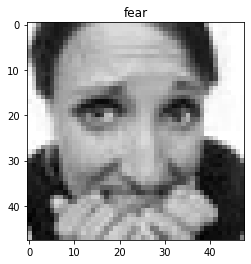

In [113]:
# Show example image
for images, labels in dataset_train.take(1):
    first_image_of_batch = images.numpy()[0]
    first_label_of_batch = labels.numpy()[0]
    assert(image_size_x * image_size_y * 3 == first_image_of_batch.size)
    fig = plt.figure(frameon=False)
    plt.imshow(first_image_of_batch.reshape(image_size_x,image_size_y,3).astype(np.uint8),cmap="gray")
    plt.title(class_names[first_label_of_batch])


In [ ]:
# Show some insights into data
all_data = iter(dataset_train.take(1)).next()[0][0].numpy().reshape(-1)
H, bins = np.histogram(all_data)

plt.bar(bins[:-1],H)
print(all_data)

In [153]:
image_size_x * image_size_y * 3 * 32

221184

In [151]:
ds_numpy = tfds.as_numpy(dataset_train)  # Convert `tf.data.Dataset` to Python generator
for ex in ds_numpy:
    batch_labels = ex[1]
    batch_images = ex[0]
    print(ex[0].reshape(-1).size)
    


221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184
221184

In [115]:
model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# verändert von https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
# dauert lange !
#model = keras.Sequential([
#    layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y, 3)),
#    tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Flatten(),
#    layers.Dense(128, activation='relu'),
#    layers.Dense(num_classes)])

In [31]:
## from practical-cnn
#normalized_train = dataset_train.map(lambda image, label: (image / 255.0, label))
#normalized_test = dataset_test.map(lambda image, label: (image / 255.0, label))
#
#model = tf.keras.Sequential()
#model.add(Input(shape=input_shape))
#model.add(Conv2D(filters=32, kernel_size=2, activation='relu')) 
#model.add(MaxPooling2D(pool_size=2))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

In [116]:
epochs=5

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)

Epoch 1/5
898/898 [==============================] - 37s 41ms/step - loss: 1.6041 - accuracy: 0.3666 - val_loss: 1.4109 - val_accuracy: 0.4606
Epoch 2/5
898/898 [==============================] - 45s 50ms/step - loss: 1.3459 - accuracy: 0.4828 - val_loss: 1.3269 - val_accuracy: 0.4886
Epoch 3/5
898/898 [==============================] - 44s 49ms/step - loss: 1.2259 - accuracy: 0.5325 - val_loss: 1.2825 - val_accuracy: 0.5130
Epoch 4/5
898/898 [==============================] - 44s 48ms/step - loss: 1.1408 - accuracy: 0.5697 - val_loss: 1.2459 - val_accuracy: 0.5293
Epoch 5/5
898/898 [==============================] - 45s 50ms/step - loss: 1.0530 - accuracy: 0.6005 - val_loss: 1.2325 - val_accuracy: 0.5291


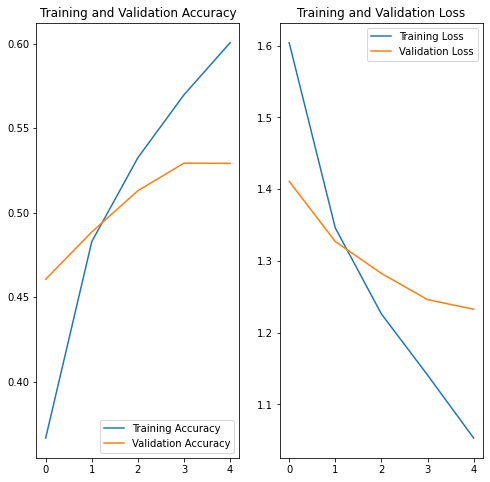

In [154]:
showHistory(history,epochs)

Diese Plots zeigen Overfitting, deshalb muss dem entgegengewirkt werden. Hierfür werden zwei Änderungen eingeführt:
- Data-Augmentation: Leichtes Verändern der Input-Bilder um "genereller" zu lernen
- Dropout 

In [155]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=input_shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [156]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)

Epoch 1/10
898/898 [==============================] - 119s 131ms/step - loss: 1.7599 - accuracy: 0.2782 - val_loss: 1.6593 - val_accuracy: 0.3468
Epoch 2/10
898/898 [==============================] - 92s 102ms/step - loss: 1.6315 - accuracy: 0.3571 - val_loss: 1.4706 - val_accuracy: 0.4323
Epoch 3/10
898/898 [==============================] - 80s 89ms/step - loss: 1.5217 - accuracy: 0.4127 - val_loss: 1.4054 - val_accuracy: 0.4540
Epoch 4/10
898/898 [==============================] - 83s 92ms/step - loss: 1.4415 - accuracy: 0.4445 - val_loss: 1.3441 - val_accuracy: 0.4841
Epoch 5/10
898/898 [==============================] - 92s 103ms/step - loss: 1.3919 - accuracy: 0.4648 - val_loss: 1.3180 - val_accuracy: 0.4957
Epoch 6/10
898/898 [==============================] - 86s 96ms/step - loss: 1.3538 - accuracy: 0.4799 - val_loss: 1.2881 - val_accuracy: 0.5078
Epoch 7/10
898/898 [==============================] - 93s 104ms/step - loss: 1.3291 - accuracy: 0.4902 - val_loss: 1.2589 - val_accu

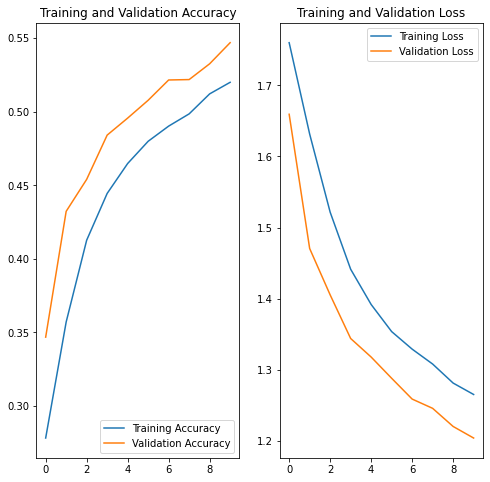

In [161]:
showHistory(history,epochs)

1/1 [==============================] - 0s 23ms/step
angry: 0.05%
disgust: 0.01%
fear: 0.16%
happy: 96.30%
neutral: 3.20%
sad: 0.23%
surprise: 0.06%


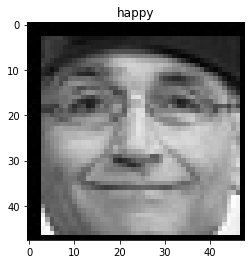

In [170]:
# show prediction for example img (took from practical-cnn)
emotion = "happy"
file = "PrivateTest_40251698"
img_path = "../data/processed/test/"+emotion+"/"+file+".jpg"
img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=image_size
) 
plt.imshow(img);
plt.title(emotion)

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
for i in range(num_classes):
    print(f'{class_names[i]}: {"{:.2f}".format(100 * predictions[0][i])}%')

In [71]:
to_be_predicted = image_dataset_from_directory(
    "../data/processed/test/", 
    image_size=image_size, 
    seed=seed,
    batch_size=batch_size)

Found 3278 files belonging to 7 classes.


In [76]:
# Let`s see some predictions
y_pred = model.predict(to_be_predicted).argmax(axis=1)
y_true = np.concatenate(list(to_be_predicted.map(lambda image, label: label).as_numpy_iterator()))
print("First ten predictions: \t", y_pred[:10])
print("First ten labels: \t", y_true[:10])

103/103 [==============================] - 2s 14ms/step
First ten predictions: 	 [2 3 6 4 4 6 6 4 4 3]
First ten labels: 	 [3 3 6 5 4 5 6 3 5 4]


In [23]:
from alibi.explainers import AnchorImage

In [24]:
predict_fn = lambda x: model.predict(x)

4/4 [==============================] - 0s 13ms/step


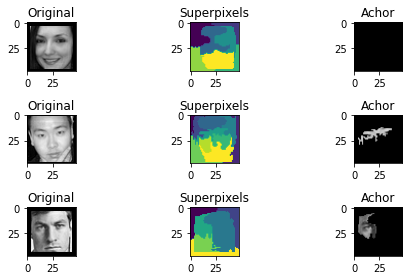

In [166]:
image= first_image_of_batch.reshape(image_size_x,image_size_y,3)

#segmentation_fn = 'felzenszwalb'
#kwargs = {'scale': 700}

segmentation_fn = 'slic'
kwargs = {'n_segments': 25, 'compactness': 10, 'sigma': .5}

explainer = AnchorImage(predict_fn, image.shape)


np.random.seed(4)
fig, axes = plt.subplots(3, 3, figsize=(8, 4))
ax = axes.ravel()

for images, labels in dataset_train.take(1):
    for i in range(0,3):
        first_image_of_batch = images.numpy()[i]
        image= first_image_of_batch.reshape(image_size_x,image_size_y,3)
        original = image.astype(np.uint8)
        explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)
        axIndex = i*3       
        ax[axIndex].imshow(original,cmap="gray",vmin=0,vmax=255)
        ax[axIndex].set_title("Original")
        ax[axIndex+1].imshow(explanation.segments)
        ax[axIndex+1].set_title("Superpixels")
        ax[axIndex+2].imshow(explanation.anchor)
        ax[axIndex+2].set_title("Achor")
        fig.tight_layout()

plt.show()

Nächste Schritte:
- "Neue" Klassifikation: "Happy" und "Not-Happy"
- Literatur-Recherche zu FER2013 -> Welche Modelle schneiden besser ab?
- Preprocessing der Bilder (z.B. Helligkeits-Angleichung o.Ä.)
- Erweiterung der Datenbasis?
- Weiter Einarbeitung in CNNs

Extract faces from images as preprocessing

In [42]:

model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size_x,image_size_y,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=num_classes,
    classifier_activation="softmax",
)

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=20
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)


Epoch 1/20
406/406 [==============================] - 88s 209ms/step - loss: 1.7947 - accuracy: 0.2905 - val_loss: 1.8693 - val_accuracy: 0.1303
Epoch 2/20
406/406 [==============================] - 95s 233ms/step - loss: 1.5919 - accuracy: 0.3927 - val_loss: 1.9205 - val_accuracy: 0.1303
Epoch 3/20
406/406 [==============================] - 91s 224ms/step - loss: 1.4690 - accuracy: 0.4514 - val_loss: 1.9489 - val_accuracy: 0.1303
Epoch 4/20
279/406 [===================>..........] - ETA: 26s - loss: 1.3942 - accuracy: 0.4829

KeyboardInterrupt: 